In [3]:
import os
import json
import csv
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from core.data_processor import DataLoader
from core.model import Model, Bayesian_LSTM
from core.tree import ScenarioTree
from core.utils import *
# from keras.utils import plot_model
from PIL import Image
import scipy.io as sio
import numpy as np
import gurobipy as grb
from gurobipy import GRB
from core.Portfolio_model_solved import *
from pylab import mpl
import seaborn as sns
# sns.set_theme(style='darkgrid') # 设置风格使图标更美观
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定字体雅黑，使图可以显示中文
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport core.tree, core.Portfolio_model_solved, core.data_processor, core.utils
# 忽略警告
import warnings
warnings.filterwarnings('ignore')

In [6]:
#读取所需参数
configs = json.load(open('config_2.json', 'r'))
if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

#读取数据
data = DataLoader(
    os.path.join('data', configs['data']['filename']),
    configs['data']['train_test_split'],
    configs['data']['columns'],
    configs['data']['output_idx']
)
#加载训练数据
train_dataset,x_train, y_train = data.get_train_data(
    seq_len=configs['data']['sequence_length'],
    batch_size=configs['training']['batch_size'],
    normalise=configs['data']['normalise']
)

#测试数据      
x_test, y_test = data.get_test_data(             seq_len=configs['data']['sequence_length'],             normalise=configs['data']['normalise']         )   

# print(x_train[-1,:,:])
print(data.len_test)

238


[Model] Model Compiled
Time taken: 0:00:00.610188


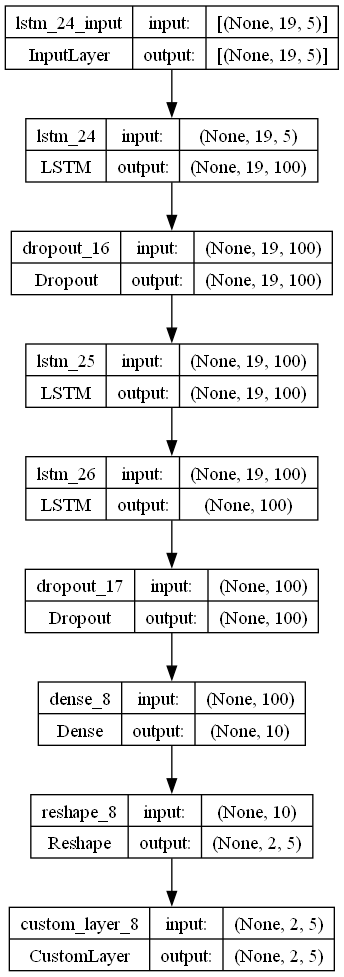

In [111]:
#创建模型
BLmodel = Bayesian_LSTM()
mymodel = BLmodel.build_model(configs)

plot_model(mymodel, to_file='./data/pic/model.png',show_shapes=True)

img = Image.open('./data/pic/model.png')
display(img)

In [112]:
#训练模型
save_model_name = BLmodel.bayesian_train(train_dataset, epochs=configs['training']['epochs'],Num_sample=configs['training']['Num_Sample'],
                         save_dir=configs['model']['save_dir'])

[Model] Training Started
Total epochs:10

Start epoch 1
Total batch:178
Current batch index:177, Curret loss:-2.1524093151092536
Start epoch 2
Total batch:178
Current batch index:177, Curret loss:-2.9592854976654053
Start epoch 3
Total batch:178
Current batch index:177, Curret loss:-2.9638931751251225
Start epoch 4
Total batch:178
Current batch index:177, Curret loss:-3.2450485229492188
Start epoch 5
Total batch:178
Current batch index:177, Curret loss:-3.2568519115448062
Start epoch 6
Total batch:178
Current batch index:177, Curret loss:-3.2247855663299566
Start epoch 7
Total batch:178
Current batch index:177, Curret loss:-3.3902313709259033
Start epoch 8
Total batch:178
Current batch index:177, Curret loss:-1.9985628128051758
Start epoch 9
Total batch:178
Current batch index:177, Curret loss:-3.2382786273956315
Start epoch 10
Total batch:178
[Model] Training Completed. Model saved as saved_models\12112023-093937-e10.h5
Time taken: 0:09:35.267645


In [104]:
# 加载之前已训练好的模型
trained_model_name = "11112023-203509-e1"
trained_model = Bayesian_LSTM()
trained_model.load_model("./saved_models/"+trained_model_name+".h5")
# trained_model.bayesian_predict(x_test,configs['data']['sequence_length'],configs['data']['sequence_length'], False)

[Model] Loading model from file ./saved_models/11112023-203509-e1.h5


In [124]:
# 生成多个情景树
# tree_model = ScenarioTree(window=x_train[-1,:,:], model=trained_model.model, T=3, branch=[1,15,8,5], n_stock=5, model_name=trained_model_name)
tree_model = ScenarioTree(window=x_train[-1,:,:], model=BLmodel.model, T=3, branch=[1,15,8,5], n_stock=5, model_name=save_model_name)
skip = 4
roll_step = data.len_test
n_tree = int(roll_step/skip)
multi_tree = tree_model.build_multi_trees(n_tree=n_tree, skip=skip, data=data.data_test) # 生成多个情景树

正在生成情景树::   5%|▌         | 3/59 [00:36<11:14, 12.04s/it]


KeyboardInterrupt: 

In [40]:
# 生成单个情景树
tree_model = ScenarioTree(window=x_test[-1,:,:], model=trained_model.model, T=3, branch=[1,15,8,5], n_stock=5, model_name=trained_model_name) # 根据训练过的模型生成情景树

# tree_model = ScenarioTree(window=x_test[-1,:,:], model=BLmodel.model, T=5, num_sample=3, model_name=save_model_name) # 根据刚训练完的模型生成情景树

s_tree = tree_model.build_tree()

Build ScenarioTree successfully!

Save data to file successfully!

Save Tree to json sucessfully!



In [120]:
# 读取情景树数据,做回测
mat_dict = {
            "ARMA-GARCH": "ag_tree_04-Nov-2023 10_49_47.mat",
            "kmeans": "kmeans_tree_04-Nov-2023 13_40_44.mat",
            "moment_matching": "mm_tree_04-Nov-2023 16_49_08.mat",
            "NN":"multitree_12112023-093937-e10.mat"
            }

wealth_change_dict = {
    "ARMA-GARCH": [],
    "kmeans": [],
    "moment_matching": [],
    "NN": []
}
decision_method = "cvar"

wealth_change_dict = backtesting(mat_dict, wealth_change_dict, data.data_test, decision_method)

正在使用cvar模型求解ARMA-GARCH对应的优化问题...

正在使用cvar模型求解kmeans对应的优化问题...

正在使用cvar模型求解moment_matching对应的优化问题...

正在使用cvar模型求解NN对应的优化问题...



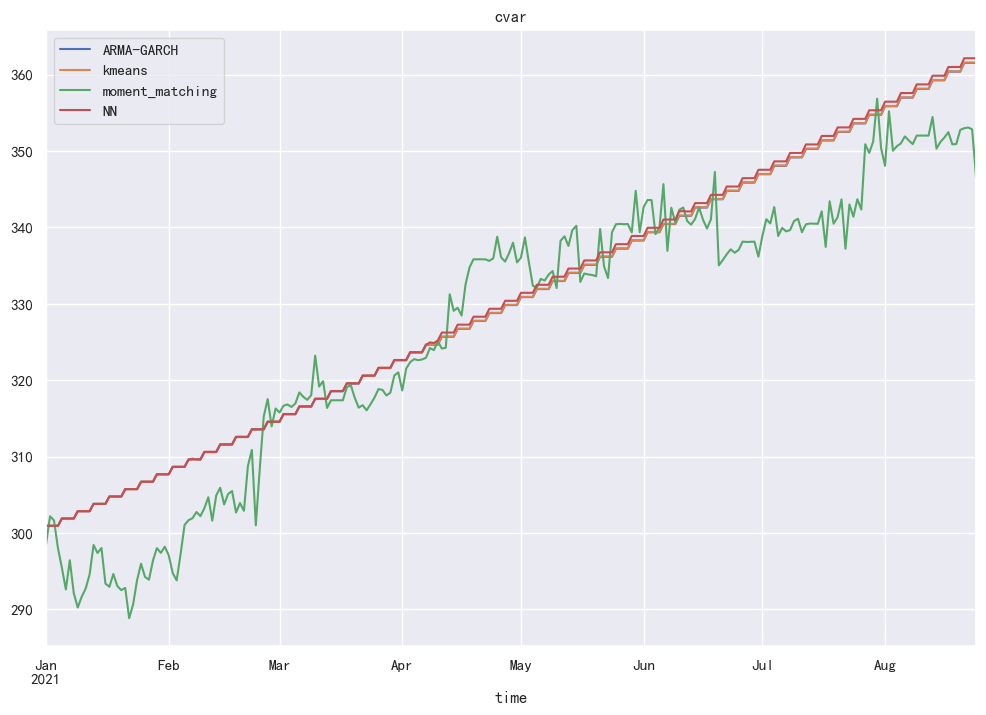

In [121]:
# 回测曲线图
# Rdata = pd.DataFrame(data.data_test, columns=['stock1', 'stock2', 'stock3', 'stock4', 'stock5'])
# Rdata['time'] = pd.date_range(start='2021-01-01', periods=len(Rdata), freq='D')
# Rdata.set_index('time', inplace=True)

# fig,ax1 = plt.subplots(figsize=(12, 8))
# ax1.set_xlabel('time')
# ax1.set_ylabel('Return')
# ax1.plot(Rdata)

w = wealth_change_dict['NN']
w = np.array(w)
periods = w.shape[0] * w.shape[1]

wealth_df = pd.DataFrame(pd.date_range(start='2021-01-01', periods= periods, freq='D'), columns=['time'])
wealth_df.set_index('time', inplace=True)

for model_name, wealth_change_list in wealth_change_dict.items():
    wealth_change_list = np.hstack(wealth_change_list)
    wealth_df[model_name] = wealth_change_list

# 保存数据
res_folder = str(4)

if not os.path.exists('./results/'+res_folder+'/'):
    os.makedirs('./results/'+res_folder+'/')


if not os.path.exists('./results/'+res_folder+'/'+save_model_name+'.xlsx'):
    wealth_df.to_excel('./results/'+res_folder+'/'+save_model_name+'.xlsx', decision_method, index=False)
else:
    try:
        with pd.ExcelWriter('./results/'+res_folder+'/'+save_model_name+'.xlsx', engine='openpyxl', mode='a') as writer:
            wealth_df.to_excel(writer, decision_method, index=False)
    except Exception as e:
        pass


wealth_df.plot(figsize=(12, 8),title=decision_method)
plt.savefig('./results/'+res_folder+'/'+decision_method+'.png')

# ax2 = ax1.twinx()
# ax2.set_ylabel('Wealth')
# ax2.plot(wealth_df)
# ax2.legend()

# print(wealth_df)

In [ ]:
# 求解优化问题

# 加载数据
datapath = './data/' + trained_model_name + '.mat'
# datapath = './data/' + save_model_name + '.mat'
treedata = sio.loadmat(datapath)
reduced_cell_tree = treedata['tree']
print(reduced_cell_tree)

reduced_branch= [12,7,5]
reduced_node=np.cumprod(reduced_branch)

# 设置参数
AX=1 # 情景树个数
d=7 #情景树节点维度
alpha=0.95
initial_wealth=300
stage=len(reduced_branch)
initial_meancvarobj=np.zeros((1,AX))
reduced_meancvarobj=np.zeros((1,AX))
initial_meancvardec=np.zeros((d-1,AX))
reduced_meancvardec=np.zeros((d-1,AX))
initial_mvobj = np.zeros((1, AX))
reduced_mvobj = np.zeros((1, AX))
initial_mvdec=np.zeros((d-1,AX))
reduced_mvdec=np.zeros((d-1,AX))
obj_diff=np.zeros((1,AX))

# Gurobi求解
for i in range(AX):
#     reduced_meancvar,reduced_x0_values = solve_portfolio_structure_tree_meancvar_decesion(d, reduced_cell_tree, initial_wealth,reduced_node, stage, reduced_branch,alpha)
    obj,x0, x = solve_portfolio_structure_tree_mv(d,reduced_cell_tree,initial_wealth,reduced_node,stage,reduced_branch,alpha)
#     reduced_meancvarobj[0, i] = reduced_meancvar
#     reduced_meancvardec[:, i] = reduced_x0_values
#     print("reduced meancvarobj", reduced_meancvarobj, "reduced_meancvardec:"
#           , reduced_meancvardec)
    print("obj", obj, "x0:", x0, "x:", x)